In [50]:
from typing import List
import cv2
import pandas as pd
import os
import numpy as np

# %matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
plt.rcParams["figure.figsize"] = (20,3)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
csv_path = "./data/1046.csv"
vid_path = "./data/1046.avi"

### The gaol here is to find a way to determine time of death using the outputs from yolov3 and the video.

## Road Map:
1. Locate areas of interest
2. Analyze areas of interest
3. Determine if the area of interest has movement

In [52]:
# Helper Functions

def get_worms(image, bbs):
    """ Takes image and list of bbs and returns a list of the
    cutouts for each worm"""
    worms = []
    for bb in bbs:
        bb = bb.astype(int)
        x, y, w, h = bb
        worm = image[y:y+h, x:x+w]
        worms.append(worm)
    
    return worms


def display_worms(worms: list[np.ndarray]):
    """List of worm images and then makes a figure with all
    the worms"""
    worm_count = len(worms)
    fig = plt.figure()
    
    for i in range(worm_count):
        fig.add_subplot(1, int(worm_count), i + 1)
        plt.imshow(worms[i])
        plt.axis('off')
    
    plt.show(block=True)
    

    

In [53]:
# Loads csv
class CSV_Reader():

    def __init__(self, csv, vid):
        """ Reads the csv and video and provides useful functions for determining
        time of death"""
        self.csv = csv
        self.vid = vid
        
        video = cv2.VideoCapture(vid)
        self.video = video
        self.frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
        
        self.df = pd.read_csv(csv, names=["frame", "x", "y", "w", "h", "class"])
        
    def get_worms_from_frame(self, frame_id):
        """ Gets the frame image from a frame id,
        and then the bounding boxes associated with that image"""
        frame = self.video.get(frame_id)
        self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_id - 1)
        ret, frame = self.video.read()
        bbs = self.df[self.df["frame"] == frame_id]
        bbs = bbs.to_numpy()
        bbs = bbs[:, 1:5]
        return frame, bbs
        

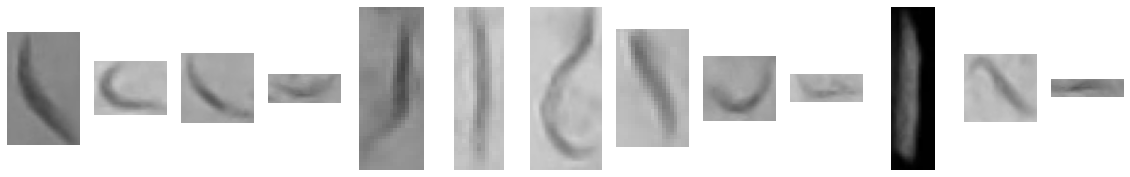

In [54]:
a = CSV_Reader(csv_path, vid_path)

frame, bbs = a.get_worms_from_frame(2400)
worms = get_worms(frame, bbs)
display_worms(worms)

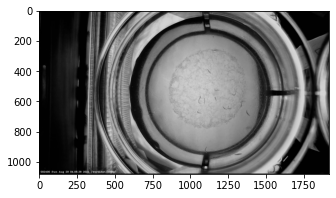

In [55]:
plt.imshow(cv2.normalize(frame, frame, 0, 255, cv2.NORM_MINMAX))

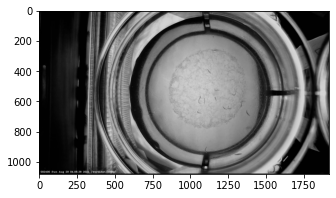

In [56]:
plt.imshow(frame)

In [57]:
df = pd.read_csv(csv_path, names=["frame", "x", "y", "w", "h", "class"])
df

,frame,x,y,w,h,class
0,1.0,1074,765,35,23,worm
1,1.0,1189,749,35,16,worm
2,1.0,1274,507,16,33,worm
3,1.0,1043,512,31,21,worm
4,1.0,851,464,18,30,worm
...,...,...,...,...,...,...
39741,2499.0,1160,570,17,33,worm
39742,2499.0,1276,546,28,18,worm
39743,2499.0,1156,520,39,15,worm
39744,2499.0,252,449,17,59,worm


In [58]:
bbs

array([[1369, 656, 27, 42],
       [1046, 661, 28, 21],
       [1214, 628, 30, 29],
       [1241, 640, 40, 16],
       [1328, 608, 17, 43],
       [1089, 578, 13, 43],
       [1050, 565, 24, 55],
       [1159, 571, 19, 31],
       [1276, 539, 30, 27],
       [1155, 519, 41, 16],
       [253, 449, 16, 60],
       [1107, 389, 34, 32],
       [1146, 259, 52, 13]], dtype=object)

In [59]:
def show_section(bb):
    bb = bb.astype(int)
    x, y, w, h = bb
    cut = frame[y:y+h, x:x+w]
    plt.imshow(cut)
    return cut

# Experiment with different image transformations.

<ipython-input-59-a88e7d883991>:5: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(cut)
<ipython-input-59-a88e7d883991>:5: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(cut)


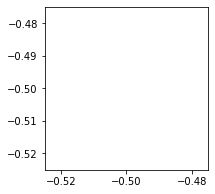

In [86]:
img = show_section(bbs[8])

TypeError: Image data of dtype object cannot be converted to float

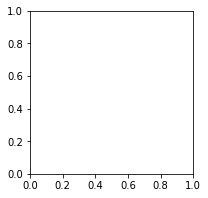

In [87]:
plt.imshow(cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX))

array([[[179, 179, 179],
        [180, 180, 180],
        [182, 182, 182],
        ...,
        [182, 182, 182],
        [181, 181, 181],
        [180, 180, 180]],

       [[178, 178, 178],
        [178, 178, 178],
        [180, 180, 180],
        ...,
        [181, 181, 181],
        [180, 180, 180],
        [179, 179, 179]],

       [[172, 172, 172],
        [172, 172, 172],
        [174, 174, 174],
        ...,
        [177, 177, 177],
        [175, 175, 175],
        [174, 174, 174]],

       ...,

       [[191, 191, 191],
        [190, 190, 190],
        [188, 188, 188],
        ...,
        [185, 185, 185],
        [187, 187, 187],
        [188, 188, 188]],

       [[207, 207, 207],
        [207, 207, 207],
        [205, 205, 205],
        ...,
        [188, 188, 188],
        [190, 190, 190],
        [191, 191, 191]],

       [[215, 215, 215],
        [215, 215, 215],
        [213, 213, 213],
        ...,
        [188, 188, 188],
        [191, 191, 191],
        [192, 192, 192]]

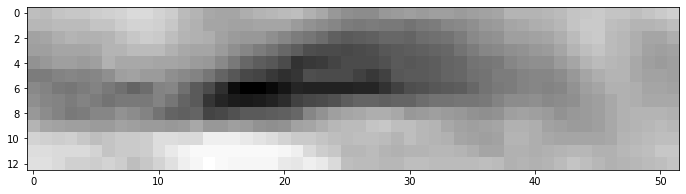

In [74]:
t = show_section(bbs[12])
cv2.blur(t, (5,5))

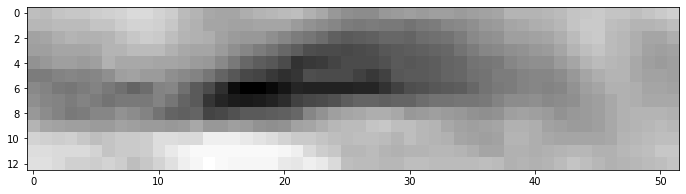

In [75]:
plt.imshow(t)
sgray = cv2.cvtColor(t, cv2.COLOR_BGR2GRAY)

In [76]:
w = t.shape[1] * 4
h = t.shape[0] * 4
resized = cv2.resize(t, (w, h), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

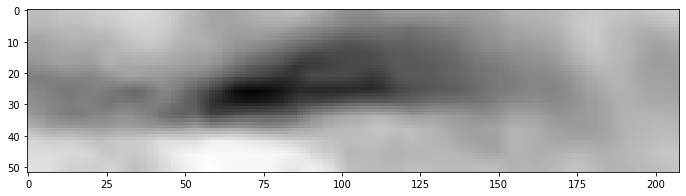

In [77]:
plt.imshow(cv2.blur(resized, (5,5)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


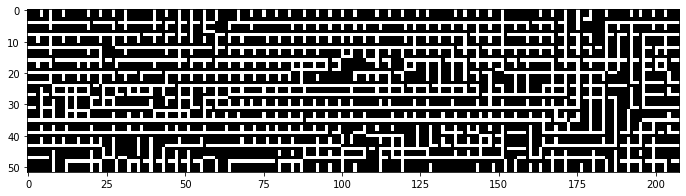

In [78]:
laplacian = cv2.Laplacian(resized, cv2.CV_64F)
plt.imshow(laplacian)

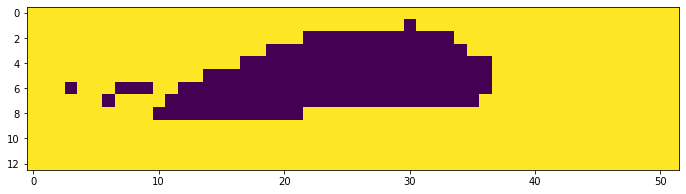

In [79]:
ret, thresh = cv2.threshold(sgray, 120, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)

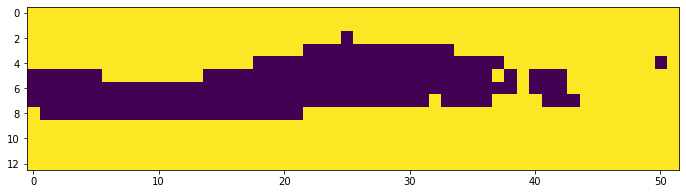

In [80]:
th2 = cv2.adaptiveThreshold(sgray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,22)
plt.imshow(th2)

## Start testing on the videos of individual worms.

___Goal is to identify when the worm moves or leaves the bounding box area.___

In [81]:
# %matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

worm_video = "results/10.avi"
video = cv2.VideoCapture(worm_video)
count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
# ret, frame = video.read()
# plt.imshow(frame)

def fetch_frame(frame_id):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = video.read()
    return frame

In [82]:
# Image transformation function

def normalization(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.normalize(frame, frame, 0, 255, cv2.NORM_MINMAX)
    return frame

def transformation(frame):
    frame = cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,22)
    return frame

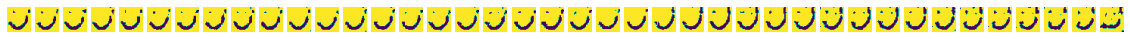

In [83]:
worms = []

for i in range(0, count, 25):
    frame = fetch_frame(i)
    frame = normalization(frame)
    frame = transformation(frame)
    worms.append(frame)

display_worms(worms)

/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'fig' is not defined

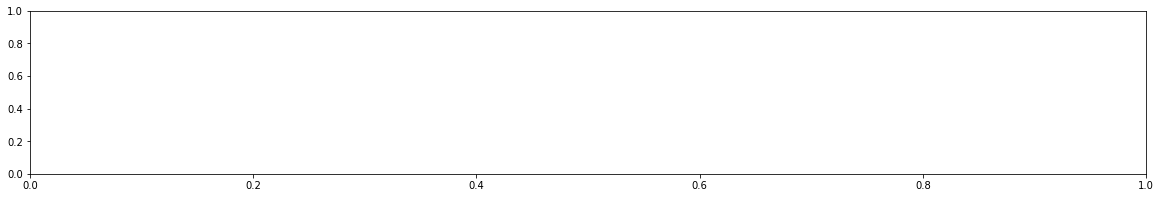

In [84]:
def calc_dif(a, b):
    a = cv2.blur(a,(2,2))
    b = cv2.blur(b,(2,2))
    
#     plt.imshow(blur)
    out = np.empty((42,26))
    diff = cv2.absdiff(a, b)
    return diff

def compute_score(worms, count=15, gap=5):
    xshape, yshape = worms[0].shape
    pixel_count = xshape * yshape
    
    differences = []
    for i, worm in enumerate(worms):
        totals = []
        low = max(0, i - count)
        for n in range(low, i - gap):
            dif = calc_dif(worms[n], worm)
            totals.append(dif.sum(axis=None))
        
        avg = np.average(totals)
        avg = avg / pixel_count
        differences.append(avg)
    

    return differences

d = calc_dif(worms[11], worms[13])
# plt.imshow(d)
data = compute_score(worms)

axs = plt.subplot()
fig.set_dpi(100)
axs.plot(data)
axs.set(ylabel = "Total Color Difference", xlabel = "frame")
# axs[0].fi
# axs[0].xlabel("Frame")
display_worms([worms[i] for i in range(0, len(worms), 2)])
plt.show()

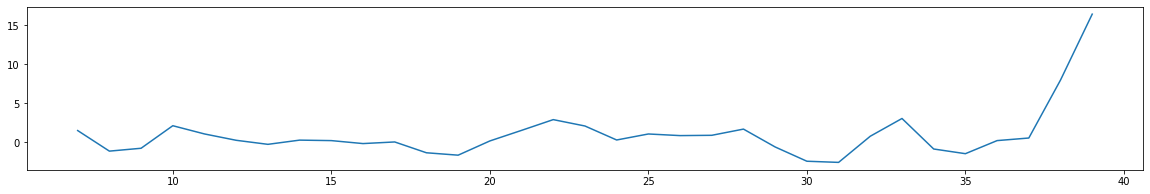

In [85]:
f = np.gradient(data)
plt.plot(f)

In [162]:
worms[0].shape


In [122]:
len(worms)